In [ ]:
# ==============================================================================
# 1. SETUP DAN INSTALASI LIBRARY
# ==============================================================================
# Uninstall versi default scikit-learn untuk memastikan tidak ada konflik.
# Kemudian, install versi library yang spesifik untuk menjamin reproduktifitas
# hasil dan konsistensi lingkungan kerja.
# ==============================================================================
!pip uninstall -y scikit-learn numpy joblib
!pip install scikit-learn==1.2.2 numpy==1.23.5 joblib==1.2.0 Sastrawi

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
Found existing installation: joblib 1.2.0
Uninstalling joblib-1.2.0:
  Successfully uninstalled joblib-1.2.0
  Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached joblib-1.2.0-py3-none-any.whl.metadata (5.3 kB)
Using cached scikit_learn-1.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.6 MB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the s

In [ ]:
# ==============================================================================
# 2. IMPORT LIBRARY YANG DIBUTUHKAN
# ==============================================================================
# Library untuk manipulasi dan analisis data
import pandas as pd
import numpy as np

# Library untuk pemrosesan teks dan regular expression
import re
import pickle
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Library utilitas lainnya
import random
from itertools import chain
from datetime import datetime

# Library dari Scikit-learn untuk machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from scipy.sparse import hstack, csr_matrix

# Library untuk interaksi dengan file di Google Colab
import joblib
from google.colab import files

In [ ]:
# ==============================================================================
# 3. MEMUAT DATA DAN INISIALISASI AWAL
# ==============================================================================
# Membaca dataset dari file CSV ke dalam DataFrame pandas
raw_data = pd.read_csv("aspirasisuya2324.csv")

# Inisialisasi Sastrawi Stemmer untuk mengubah kata ke bentuk dasarnya
stemmer = StemmerFactory().create_stemmer()

# Daftar stopwords kustom untuk menghapus kata-kata umum yang tidak signifikan
stopwords = set([
    'yang','dan','di','ke','dari','untuk','pada','dengan',
    'saya','kami','adalah','itu','ini','juga','atau','agar',
    'mahasiswa','kelas','lebih','baik','ha','tu'
])

# Daftar kata pengecualian yang tidak akan di-stemming karena sudah merupakan
# istilah penting dalam konteks ini.
exceptions = {'dosen','kelas','kuliah','materi','pembelajaran','administrasi',
              'belajar','zoom','tugas','rekaman','offline','online','sks','ukt','krs'}

# ==============================================================================
# 4. DEFINISI FUNGSI UNTUK PEMROSESAN TEKS
# ==============================================================================

def clean_text(text):
    """
    Fungsi untuk membersihkan teks aspirasi melalui beberapa tahap:
    1. Mengubah teks menjadi huruf kecil.
    2. Menghapus semua karakter selain huruf dan spasi.
    3. Menghapus imbuhan kepemilikan (nya, ku, mu) dan partikel (lah, pun).
    4. Menghapus kata yang diulang (misal: 'masalah-masalah' menjadi 'masalah').
    5. Menghapus angka penanda jamak (misal: 'barang2' menjadi 'barang').
    6. Menghapus stopwords.
    7. Melakukan stemming pada kata, kecuali kata tersebut ada di daftar 'exceptions'.
    """
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\b(\w+)(nya|ku|mu|lah|pun)\b', r'\1', text)
    text = re.sub(r'(\w+)-\1\b', r'\1', text)
    text = re.sub(r'(\w+)2\b', r'\1', text)
    words = text.split()
    words = [w for w in words if w not in stopwords]
    words = [w if w in exceptions else stemmer.stem(w) for w in words]
    return ' '.join(words)

def is_clean_text(text):
    """
    Fungsi untuk memvalidasi apakah sebuah teks layak diproses atau tidak.
    Teks dianggap tidak layak jika:
    1. Terlalu pendek (kurang dari 8 karakter atau kurang dari 3 kata).
    2. Mengandung teks placeholder (misal: 'isi disini').
    """
    txt = str(text).lower()
    if len(txt) < 8 or len(txt.split()) < 3:
        return False
    placeholders = ['masukan aspirasimu','isi disini','tulis disini']
    return not any(ph in txt for ph in placeholders)

def augment_text(text, p=0.2):
    """
    Fungsi untuk augmentasi data dengan cara menghapus kata secara acak.
    Ini digunakan untuk membuat variasi data pada kelas minoritas.
    Parameter 'p' adalah probabilitas sebuah kata akan dihapus.
    """
    words = text.split()
    if len(words) <= 3: return text
    new_words = [w for w in words if random.random() > p]
    return ' '.join(new_words) if new_words else text

In [ ]:
# ==============================================================================
# 5. PEMBERSIHAN, TRANSFORMASI, DAN PENYEIMBANGAN DATA
# ==============================================================================

# Menghapus baris yang memiliki nilai kosong pada kolom 'aspirasi' atau 'kategori'
raw_data.dropna(subset=['aspirasi','kategori'], inplace=True)

# Menerapkan fungsi clean_text pada setiap baris di kolom 'aspirasi'
raw_data['cleaned'] = raw_data['aspirasi'].apply(clean_text)

# Menyaring data dan hanya menyimpan baris yang lolos validasi is_clean_text
raw_data = raw_data[raw_data['cleaned'].apply(is_clean_text)]

# Menggabungkan kategori 'pembelajaran offline' dan 'pembelajaran online'
# menjadi satu kategori 'pembelajaran' untuk menyederhanakan klasifikasi.
raw_data['kategori'] = raw_data['kategori'].replace({
    'pembelajaran offline':'pembelajaran',
    'pembelajaran online':'pembelajaran'
})

# --- Penyeimbangan Kelas (Oversampling & Undersampling) ---
# Tujuannya adalah membuat jumlah data untuk setiap kategori seimbang agar
# model tidak bias terhadap kategori mayoritas.

labels = ['fasilitas', 'dosen', 'ormawa', 'pembelajaran', 'administrasi']
target_per_class = 150  # Target jumlah sampel untuk setiap kelas
sampled = []

for lbl in labels:
    subset = raw_data[raw_data['kategori'] == lbl]
    n = len(subset)
    if n == 0: continue

    if n < target_per_class:
        # Jika data kurang dari target (Oversampling dengan Augmentasi)
        aug_needed = target_per_class - n
        extra = subset.sample(n=aug_needed, replace=True, random_state=42)
        extra['cleaned'] = extra['cleaned'].apply(lambda x: augment_text(x, p=0.2))
        subset = pd.concat([subset, extra])
    else:
        # Jika data lebih dari target (Undersampling)
        subset = subset.sample(n=target_per_class, random_state=42)

    sampled.append(subset)

# Gabungkan semua data yang sudah diseimbangkan menjadi satu DataFrame baru
data = pd.concat(sampled, ignore_index=True)

/tmp/ipython-input-3-349910781.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data['kategori'] = raw_data['kategori'].replace({


In [ ]:
# ==============================================================================
# 6. REKAYASA FITUR (FEATURE ENGINEERING)
# ==============================================================================
# Mengubah teks menjadi fitur numerik yang dapat diproses oleh model.
# Kami menggunakan kombinasi beberapa jenis fitur untuk meningkatkan akurasi.

# --- Fitur 1: TF-IDF ---
# Mengukur seberapa penting sebuah kata dalam dokumen relatif terhadap korpus.
# ngram_range=(1, 3) akan mempertimbangkan frasa hingga 3 kata.
tfidf = TfidfVectorizer(max_features=4000, ngram_range=(1, 3), min_df=2, sublinear_tf=True)
X_tfidf = tfidf.fit_transform(data['cleaned'])

# --- Fitur 2: Panjang Teks ---
# Jumlah kata dalam teks bisa menjadi indikator yang berguna.
data['text_len'] = data['cleaned'].apply(lambda x: len(x.split()))
X_len = csr_matrix(data['text_len'].values.reshape(-1, 1))

# --- Fitur 3 & 4: Kehadiran dan Jumlah Kata Kunci Prioritas ---
# Menggunakan domain knowledge untuk mengidentifikasi kata kunci yang sangat
# relevan untuk setiap kategori.
prioritized_keywords = {
    'fasilitas': [
        'gedung', 'ruang kelas', 'kursi', 'meja', 'papan tulis', 'proyektor',
        'ac', 'kipas', 'atap', 'bocor', 'wc', 'toilet', 'bersih', 'kotor',
        'wifi', 'internet', 'lambat', 'parkir', 'aman', 'laboratorium', 'lab'
    ],
    'dosen': [
        'dosen', 'pengajar', 'cara mengajar', 'penjelasan dosen', 'menjelaskan',
        'tidak hadir', 'telat', 'marah', 'killer', 'galak', 'asik',
        'susah dihubungi', 'pelit nilai', 'tidak adil', 'sikap dosen'
    ],
    'pembelajaran': [
        'belajar', 'pembelajaran', 'materi', 'bahan ajar', 'kurikulum', 'sulit', 'tidak paham',
        'zoom', 'rekaman', 'gmeet', 'offline', 'online', 'hybrid',
        'tugas', 'kuis', 'ujian', 'uts', 'uas', 'praktikum', 'jadwal kuliah', 'bentrok'
    ],
    'ormawa': [
        'ormawa', 'himaprodi', 'himpunan', 'bem', 'ukm', 'lkm',
        'kegiatan', 'event', 'proker', 'program kerja', 'panitia', 'camp'
    ],
    'administrasi': [
        'sks', 'krs', 'ukt', 'biaya', 'bayar', 'pembayaran', 'tagihan',
        'admin', 'administrasi', 'birokrasi', 'lambat', 'sulit', 'cuti',
        'registrasi', 'siakad', 'layanan akademik', 'keuangan'
    ]
}

# Buat daftar unik semua kata kunci
flat_keywords = list(set(chain.from_iterable(prioritized_keywords.values())))

# Fitur 3: Kehadiran setiap kata kunci (sebagai one-hot encoding)
kw_vec = CountVectorizer(vocabulary=flat_keywords)
X_kw = kw_vec.fit_transform(data['cleaned'])

# Fitur 4: Jumlah total kata kunci yang muncul dalam teks
data['kw_count'] = data['cleaned'].apply(lambda x: sum(1 for w in x.split() if w in flat_keywords))
X_kwcount = csr_matrix(data['kw_count'].values.reshape(-1, 1))

# --- Menggabungkan Semua Fitur ---
# Semua matriks fitur (TF-IDF, panjang teks, kehadiran keyword, jumlah keyword)
# digabungkan secara horizontal menjadi satu matriks fitur utama 'X'.
X = hstack([X_tfidf, X_kw, X_len, X_kwcount])


In [ ]:
# ==============================================================================
# 7. PERSIAPAN DATA UNTUK PELATIHAN MODEL
# ==============================================================================
# Mengubah label kategori (teks) menjadi angka (numerik)
le = LabelEncoder()
y = le.fit_transform(data['kategori'])

# Membagi data menjadi data latih (80%) dan data uji (20%)
# 'stratify=y' memastikan proporsi kelas di data latih dan uji sama.
# Kita juga memisahkan indeks agar bisa melacak data asli setelah prediksi.
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, data.index, stratify=y, test_size=0.2, random_state=42

)

In [ ]:
# ==============================================================================
# 8. PENCARIAN HIPERPARAMETER (HYPERPARAMETER TUNING) DENGAN GRIDSEARCHCV
# ==============================================================================
# Tujuannya adalah menemukan kombinasi parameter terbaik untuk RandomForest
# agar mendapatkan performa model yang paling optimal.

# Definisikan rentang parameter yang akan diuji
param_grid = {
    'n_estimators': [300, 500, 700],      # Jumlah pohon dalam forest
    'max_depth': [10, 20, None],          # Kedalaman maksimum pohon
    'min_samples_split': [2, 5],          # Jumlah sampel minimum untuk membagi node
    'min_samples_leaf': [1, 2],           # Jumlah sampel minimum di daun
    'max_features': ['sqrt', 'log2']      # Jumlah fitur yang dipertimbangkan saat split
}

# Gunakan StratifiedKFold untuk cross-validation, menjaga distribusi kelas
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inisialisasi GridSearchCV
grid = GridSearchCV(
    estimator=RandomForestClassifier(
        random_state=42,
        class_weight='balanced_subsample', # Memberi bobot pada kelas secara seimbang
        n_jobs=-1                          # Menggunakan semua core CPU
    ),
    param_grid=param_grid,
    scoring='f1_macro', # Metrik evaluasi yang baik untuk multi-kelas, fokus pada F1-score rata-rata
    cv=cv_strategy,
    verbose=2,         # Menampilkan progress pencarian
    n_jobs=-1          # Menjalankan pencarian secara paralel
)

# Latih GridSearchCV pada data latih
print("Memulai pencarian hiperparameter...")
grid.fit(X_train, y_train)

# Simpan model terbaik yang ditemukan oleh GridSearchCV
best_model = grid.best_estimator_

# Cetak kombinasi parameter terbaik
print("✅ Parameter terbaik ditemukan:", grid.best_params_)


Memulai pencarian hiperparameter...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
✅ Parameter terbaik ditemukan: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}



Skor F1 hasil Cross-Validation: [0.78113076 0.86666147 0.85688328 0.82919474 0.8483289 ]
Rata-rata skor F1 CV: 0.8364398285160103

Laporan Klasifikasi (Classification Report):

              precision    recall  f1-score   support

administrasi       0.86      0.83      0.85        30
       dosen       0.71      0.80      0.75        30
   fasilitas       0.90      0.90      0.90        30
      ormawa       0.94      0.97      0.95        30
pembelajaran       0.69      0.60      0.64        30

    accuracy                           0.82       150
   macro avg       0.82      0.82      0.82       150
weighted avg       0.82      0.82      0.82       150



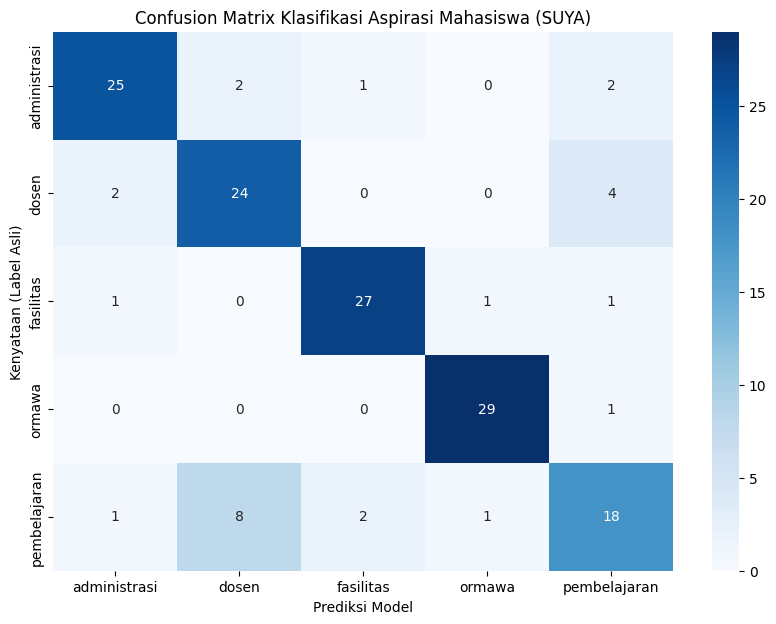

In [ ]:
# ==============================================================================
# 9. EVALUASI MODEL TERBAIK
# ==============================================================================

# Evaluasi menggunakan Cross-Validation pada keseluruhan data untuk mendapatkan
# gambaran performa yang lebih stabil dan andal.
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='f1_macro')
print("\nSkor F1 hasil Cross-Validation:", cv_scores)
print("Rata-rata skor F1 CV:", np.mean(cv_scores))

# Lakukan prediksi pada data uji
y_pred = best_model.predict(X_test)

# Tampilkan laporan klasifikasi yang berisi precision, recall, dan f1-score
labels_eval = le.classes_
print("\nLaporan Klasifikasi (Classification Report):\n")
print(classification_report(y_test, y_pred, target_names=labels_eval))

# Visualisasi Confusion Matrix untuk melihat performa model per kelas
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_eval,
            yticklabels=labels_eval)
plt.xlabel("Prediksi Model")
plt.ylabel("Kenyataan (Label Asli)")
plt.title("Confusion Matrix Klasifikasi Aspirasi Mahasiswa (SUYA)")
plt.show()

In [ ]:
# ==============================================================================
# 9.5 ANALISIS KESALAHAN PREDIKSI (ERROR ANALYSIS)
# ==============================================================================
# Tujuannya adalah untuk melihat secara spesifik data mana yang salah diprediksi
# oleh model. Ini sangat berguna untuk memahami kelemahan model dan mencari
# ide untuk perbaikan (misalnya, menambah kata kunci baru atau memperbaiki
# pra-pemrosesan).

# Cari indeks dari data uji di mana prediksi (y_pred) tidak sama dengan label asli (y_test)
incorrect_indices = np.where(y_pred != y_test)[0]

# Dapatkan indeks asli dari DataFrame 'data' untuk sampel yang salah diprediksi
misclassified_indices = idx_test[incorrect_indices]

# Ambil data asli, prediksi yang salah, dan label asli dari sampel-sampel tersebut
misclassified_samples = data.loc[misclassified_indices]
true_labels = le.inverse_transform(y_test[incorrect_indices])
predicted_labels = le.inverse_transform(y_pred[incorrect_indices])

# Buat DataFrame baru untuk menampilkan kesalahan secara rapi
df_errors = pd.DataFrame({
    'Teks Asli': misclassified_samples['aspirasi'],
    'Teks Cleaned': misclassified_samples['cleaned'],
    'Kategori Asli': true_labels,
    'Prediksi Model': predicted_labels
})

# Tampilkan DataFrame kesalahan
print("\n" + "="*50)
print("ANALISIS KESALAHAN PREDIKSI PADA DATA UJI")
print("="*50)

if df_errors.empty:
    print("\n✅ Luar biasa! Tidak ada kesalahan prediksi pada data uji.")
else:
    print(f"\nModel membuat {len(df_errors)} kesalahan prediksi dari total {len(y_test)} data uji.")
    print("Berikut adalah beberapa contoh kesalahan prediksi:\n")
    # Atur opsi display pandas agar teks panjang tidak terpotong
    pd.set_option('display.max_colwidth', 200)
    display(df_errors.head(15)) # Tampilkan 15 kesalahan pertama

print("\n" + "="*50)
print("Gunakan tabel di atas untuk menganalisis:")
print("1. Apakah teksnya ambigu? (Contoh: 'Dosen telat memulai kelas online')")
print("2. Apakah proses cleaning menghilangkan konteks penting?")
print("3. Apakah ada kata kunci baru yang bisa ditambahkan untuk kategori tertentu?")
print("="*50 + "\n")


ANALISIS KESALAHAN PREDIKSI PADA DATA UJI

Model membuat 27 kesalahan prediksi dari total 150 data uji.
Berikut adalah beberapa contoh kesalahan prediksi:



,Teks Asli,Teks Cleaned,Kategori Asli,Prediksi Model
688,"Untuk program studi Ilmu Komunikasi, \nBanyak sekali program MBKM yang bisa kami ikuti bahkan mulai dari semester 2.. \nNamun, sangat disayangkan bila mana konversi hanya boleh saat semester 6 sed...",program il komunikasi banyak sekali program bisa mulai semester namun sangat sayang mana konversi boleh saat sedang laku belum semester paksa harus kejar dua banyak alhasil ada sa tidak maksimal k...,administrasi,dosen
744,ketika ke TU responnya kurang meng enakkan,ketika kurang enak,administrasi,fasilitas
482,"bu erlin dolphin dosen dasar Pancasila semester 2, sudah 3 pertemuan tanpa kelas dan tidak ada pemberitahuan informasi kelasnya. sia"" bayar sks matkul ini wkwk",bu erlin dolphin dosen dasar pancasila semester sudah temu tanpa tidak ada pemberitahuan informasi sia bayar sks matkul wkwk,pembelajaran,dosen
455,Tidak jarang dosen yang hanya share materi tapi sedikit menjelaskan,tidak jarang dosen share materi tapi sedikit jelas,pembelajaran,dosen
176,Ada dosen yang mengajar hanya sekali (merupakan pelajaran online),ada dosen ajar sekali rupa ajar online,dosen,pembelajaran
215,Untuk dosen yang mata kuliah online dimohon untuk selalu memberi kabar di grup,dosen mata kuliah online mohon selalu beri kabar grup,dosen,pembelajaran
648,"respon TU tergolong kurang cepat, laporan tidak mendapat followup padahal sudah menberi nomor WA yang dapat dihubungi",respon golong kurang cepat lapor tidak dapat followup padahal sudah menberi nomor wa dapat hubung,administrasi,pembelajaran
594,"Beberapa dosen tidak komunikatif, dan tidak memberikan perintah tugas dengan jelas",beberapa dosen tidak komunikatif tidak beri perintah tugas jelas,pembelajaran,dosen
540,"tolong penjagaan kampus diperketat terutama diarea FIK maupun Camp ormawa, ini real pengalaman yang saya alami karena beberapakali sempat kejadian ada orang dari luar (bapak"") masuk foodcourt/ cam...",tolong jaga kampus ketat utama area fik mau camp ormawa real alam alami karena beberapakali sempat jadi ada orang luar bapak masuk foodcourt camp ormawa masuk sampai dalam camp jual dagang cara ke...,pembelajaran,ormawa
226,Kaprodi kurang responsif terhadap masalah perkuliahan yang dialami mahasiswa,kaprodi kurang responsif hadap masa kuliah alami,dosen,administrasi



Gunakan tabel di atas untuk menganalisis:
1. Apakah teksnya ambigu? (Contoh: 'Dosen telat memulai kelas online')
2. Apakah proses cleaning menghilangkan konteks penting?
3. Apakah ada kata kunci baru yang bisa ditambahkan untuk kategori tertentu?



In [ ]:
# ==============================================================================
# 10. PENYIMPANAN MODEL DAN ARTEFAK LAINNYA (VERSI STABIL TANPA TIMESTAMP)
# ==============================================================================

# Nama file tetap (agar tidak berubah-ubah dan bisa di-load dengan mudah)
model_name = "suya_rf_model.pkl"
vectorizer_name = "suya_tfidf_vectorizer.pkl"
label_encoder_name = "suya_label_encoder.pkl"
keywords_name = "suya_prioritized_keywords.pkl"

# Simpan file menggunakan joblib (lebih aman daripada pickle biasa untuk model scikit-learn)
joblib.dump(best_model, model_name)
joblib.dump(tfidf, vectorizer_name)
joblib.dump(le, label_encoder_name)
joblib.dump(prioritized_keywords, keywords_name)

print("\n✅ Model dan artefak berhasil disimpan:")
print(f"📦 Model: {model_name}")
print(f"🧠 TF-IDF Vectorizer: {vectorizer_name}")
print(f"🏷️ Label Encoder: {label_encoder_name}")
print(f"🔑 Prioritized Keywords: {keywords_name}")

# Otomatis unduh file (khusus jika dijalankan di Google Colab)
try:
    from google.colab import files
    print("\nMengunduh file...")
    files.download(model_name)
    files.download(vectorizer_name)
    files.download(label_encoder_name)
    files.download(keywords_name)
except:
    print("📂 File siap digunakan, tapi tidak bisa diunduh otomatis (bukan di Colab).")



✅ Model dan artefak berhasil disimpan:
📦 Model: suya_rf_model.pkl
🧠 TF-IDF Vectorizer: suya_tfidf_vectorizer.pkl
🏷️ Label Encoder: suya_label_encoder.pkl
🔑 Prioritized Keywords: suya_prioritized_keywords.pkl

Mengunduh file...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>